In [3]:
import os, sys
import yaml

cwd = os.getcwd()
sys.path.append(os.path.dirname(cwd))
from utils import layers_residual
from utils import layers_new

from utils import models_generator as models_gen
from utils import models_discriminator as models_dis
from utils import models_cyclegan as models_gan
from utils import models_classifyer as models_class

from utils import preprocessing as pre

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
import seaborn as sns

# Load classifyer

It is the same model used when evaluating the temperature difference durring training. This model is itself evaluated in the notebook Evaluate_classifyer.ipynb

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 21)]    0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512, 64)      1344        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_176 (Conv1D)             (None, 512, 64)      36928       dense_6[0][0]                    
__________________________________________________________________________________________________
sequential_27 (Sequential)      (None, 512, 64)      74368       conv1d_176[0][0]                 
____________________________________________________________________________________________

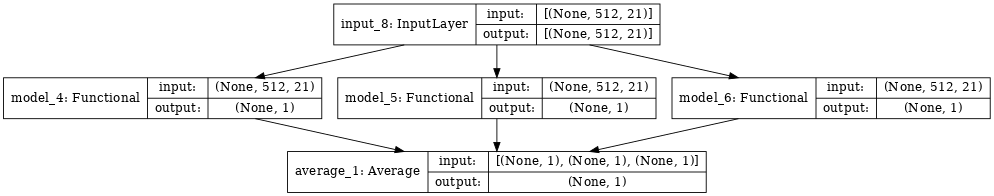

In [7]:
models_weights = ["../weights/NEW_MODELS/Model1/variables/variables", "../weights/NEW_MODELS/Model2/variables/variables", "../weights/NEW_MODELS/Model3/variables/variables"]
names = ["model1", "model2", "model3"]
file = "../config/Classifier/config_classifier1.yaml"
with open(file, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model_input = tf.keras.layers.Input(shape=(512,21))
model1 = models_class.get_classifier(config['Classifier'], 21)
model2 = models_class.get_classifier(config['Classifier'], 21)
model3 = models_class.get_classifier(config['Classifier'], 21)

output1 = model1(model_input)
output2 = model2(model_input)
output3 = model3(model_input)

model1.summary()

model1.load_weights(models_weights[0])
model2.load_weights(models_weights[1])
model3.load_weights(models_weights[2])


ensemble_output = tf.keras.layers.Average()([output1, output2, output3])
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.summary()
tf.keras.utils.plot_model(ensemble_model, show_shapes=True, dpi=64)

# Load Cycle gan

In [11]:
# result dir
result_dir = "../results/20211106-213244config1.yaml"

# Config file
config_file = os.path.join(result_dir, "config.yaml")

# Weights
weights_file = os.path.join(result_dir, "weights/cycle_gan_model")

with open(config_file, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model = models_gan.CycleGan(config)
model.load_weights(weights_file)
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

[256, 256, 256, 256, 256, 256, 256, 256, 256]
8
[256, 256, 256, 256, 256, 256, 256, 256, 256]
8
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 512, 21)]    0                                            
__________________________________________________________________________________________________
conv1d_482 (Conv1D)             (None, 512, 64)      12160       input_22[0][0]                   
__________________________________________________________________________________________________
instance_normalization_206 (Ins (None, 512, 64)      128         conv1d_482[0][0]                 
__________________________________________________________________________________________________
conv1d_483 (Conv1D)             (None, 256, 128)     73856       instance_normalization_206[0]

# Load Data

In [34]:
# Change path to home computer!!!!!!!
    # Load training data
    #base_dir: '/data/Mesophiles'
    #train_dir: 'train/*.tfrecord'
    #val_dir: 'val/*.tfrecord'
    
config["Data_meso"]['base_dir'] = '../data/Combined_data/published/Groups_5/RECORDS_REG_GLOBAL/'
config["Data_meso"]['val_dir'] = 'test/*.tfrecord'
config["Data_thermo"]['base_dir'] = '../data/Combined_data/published/Groups_2/Thermophiles/'
data_train_meso, data_val_meso = pre.load_data(config["Data_meso"], model="cycle_gan")
data_train_thermo, data_val_thermo = pre.load_data(config["Data_thermo"], model="cycle_gan")
data = {'meso_train': data_train_meso, 'thermo_train': data_train_thermo, 'meso_val':data_val_meso , 'thermo_val': data_val_thermo}





# Generate sequences

In [40]:
dict_combined = {"Id":[], "seq":[], "pOGT":[]}

val_x = data['meso_val'].batch(32, drop_remainder=False)
val_y = data['thermo_val'].batch(32, drop_remainder=False)

count = 0
for batch in zip(val_x, val_y):
    fake_y = model.generate_step(batch)
    true_x = batch[0][0]
    w_x = tf.cast(tf.reshape(batch[0][2], shape=(32,512)), dtype=tf.int64).numpy()
    
    # make predictions
    
    seqs=[]
    for seq, w in zip(list(tf.math.argmax(true_x.numpy(),axis=-1).numpy()), list(w_x)):
                seqs.append(pre.convert_table(seq, tf.reshape(w, shape=(512,))))   
    
    for seq_thermo, seq_meso, w in zip(fake_y, seqs, w_x):
        idx = np.sum(w)
        dict_combined["Id"].append(str(count))
        dict_combined["seq"].append(seq_meso[:idx])
        dict_combined["Id"].append(str(count) + "_M")
        dict_combined["seq"].append(seq_thermo[:idx])
        count+=1
pass

# Write fasta

In [44]:
FASTA_STRING=">{}\n{}\n"

with open("fasta_combined_test.fasta", "w") as f:
    for id_, seq in zip(dict_combined["Id"], dict_combined["seq"]):
        f.write(FASTA_STRING.format(id_, seq))

# Align

In [45]:
! clustalo -i fasta_combined_test.fasta -o dist_combined_test.ali --distmat-out=dist_combined_test.dist --full

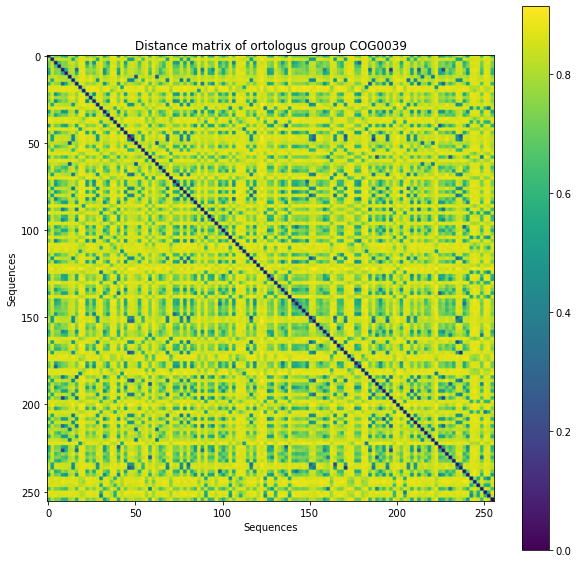

In [51]:
from Bio import SeqIO
file_dist = "dist_combined_test.dist"
file_fasta= "fasta_combined_test.fasta"

dict_fasta = {}
#for rec in SeqIO.parse(file_fasta, 'fasta'):
#    dict_fasta[rec.id] = float(rec.description.split()[-1])

with open(file_dist, 'r') as file_reader:
    for i, line in enumerate(file_reader.readlines()):
        if i == 0:

            n_entries = int(line[:-1])
            dict_dist = {}
            mat_dist  = np.zeros((n_entries, n_entries))
        else:
            elements = line[:-1].split()

            mat_dist[i-1, :] = [float(element) for element in elements[1:]]
            #dict_dist[elements[0]] = (np.array([float(element) for element in elements[1:]]), dict_fasta[elements[0]])
plt.figure(figsize=[10,10])
plt.imshow(mat_dist)
plt.colorbar()
plt.title("Distance matrix of ortologus group {}".format("COG0039"))
plt.xlabel("Sequences")
plt.ylabel("Sequences")
plt.savefig("COG0039_distmat.png")

In [52]:
import numba
@numba.njit()
def hue(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    delta = cmax - cmin
    if cmax == r:
        return ((g - b) / delta) % 6
    elif cmax == g:
        return ((b - r) / delta) + 2
    else:
        return ((r - g) / delta) + 4

@numba.njit()
def lightness(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    return (cmax + cmin) / 2.0

@numba.njit()
def saturation(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    chroma = cmax - cmin
    light = lightness(r, g, b)
    if light == 1:
        return 0
    else:
        return chroma / (1 - abs(2*light - 1))

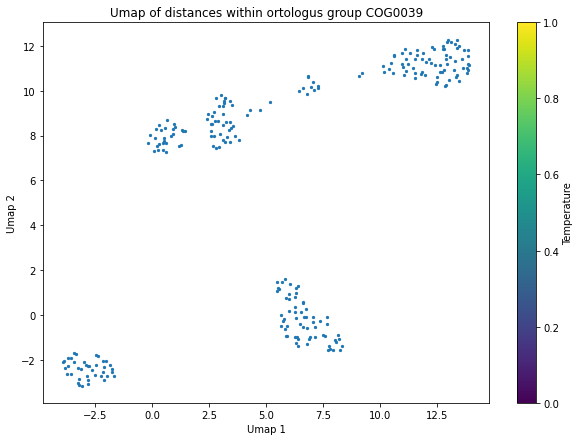

In [54]:
import umap
#ogt = [t[-1][-1] for t in dict_dist.items()]
reducer = umap.UMAP(n_neighbors=50, min_dist = 0.5, metric = 'manhattan')
reducer.fit(mat_dist)
X_umap = reducer.transform(mat_dist)
plt.figure(figsize=[10,7])
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], s=5)# c=ogt, s = 5)
plt.colorbar(label = "Temperature")
plt.title('Umap of distances within ortologus group {}'.format("COG0039"))
#handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = plt.legend(handles, ['Thermophiles', 'Mesophiles'], loc="upper right", title="Distributions")
plt.xlabel('Umap 1')
plt.ylabel('Umap 2')
plt.savefig("{}_similarity_umap.png".format("COG0039"))

In [11]:
file = "../config/Cycle_gan/config_home.yaml"
with open(file, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model = models_gan.CycleGan(config, name = "gan")

True
Tensor("Placeholder:0", shape=(None, 512, 21), dtype=float32)
[<tf.Tensor 'Generator_thermo/Generator_thermo_up_down_0_norm/batchnorm/add_1:0' shape=(None, 256, 64) dtype=float32>, <tf.Tensor 'Generator_thermo/Generator_thermo_up_down_1_norm/batchnorm/add_1:0' shape=(None, 128, 128) dtype=float32>]
True
Tensor("Placeholder:0", shape=(None, 512, 21), dtype=float32)
[<tf.Tensor 'Generator_meso/Generator_meso_up_down_0_norm/batchnorm/add_1:0' shape=(None, 256, 64) dtype=float32>, <tf.Tensor 'Generator_meso/Generator_meso_up_down_1_norm/batchnorm/add_1:0' shape=(None, 128, 128) dtype=float32>]
Model: "Generator_thermo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_thermo_gumbel (Gum multiple                  1         
_________________________________________________________________
Generator_thermo_sn_in_proj  multiple                  1408      
__________________________________________

In [12]:
model.save_gan("test")

In [13]:
model.load_gan("test")